<a href="https://colab.research.google.com/github/drorrusso/ai-learning-playground/blob/main/DCGAN_generate_handwritten_digits_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN with PyTorch

This notebook is based on hands-on practice of the Coursera workshop: [Deep learning with PyTorch : build a Generative Adversarial Network](https://www.coursera.org/projects/deep-learning-with-pytorch-generative-adversarial-network) with small changes and additional explainatory documnetation I've added. The scope here is a private case of GAN that involves generation of images, called DCGAN (e.g. Deep Convolutional GAN).

#### What is DCGAN?
DCGAN, or Deep Convolutional Generative Adversarial Network, is a type of neural network architecture used for generating new data. It belongs to a larger class of models called Generative Adversarial Networks (GANs).

Here's a breakdown of how it works:

* **Two parts working together:** A DCGAN consists of two main components: a generator and a discriminator.
* **Generator:** The generator acts like an artist, trying to create new, realistic data (like images) that mimics the data it  trained on.
* **Discriminator:** The discriminator acts like an art critic, trying to determine if the data it's shown is real (from the training data) or fake (generated by the generator).

Through a process of competition and refinement, the generator gets better at creating realistic data, and the discriminator gets better at spotting fakes.

Here are some key features of DCGANs:

* **Convolutional layers:**  They rely on convolutional layers instead of fully connected layers, making them well-suited for image data.
* **Strided vs fractional-strided convolutions:** DCGANs use specific types of convolutions: strided convolutions in the discriminator for capturing features and fractional-strided convolutions (also called transposed convolutions) in the generator for upsampling data.
* **Batch normalization:** This technique helps the network train faster and more stably.

Overall, DCGANs are a powerful tool for generating new data and have been used for various applications like creating realistic images of faces, generating new clothing designs, and even creating music.

#### How does it work?
*This is the original course image explaining this project:*
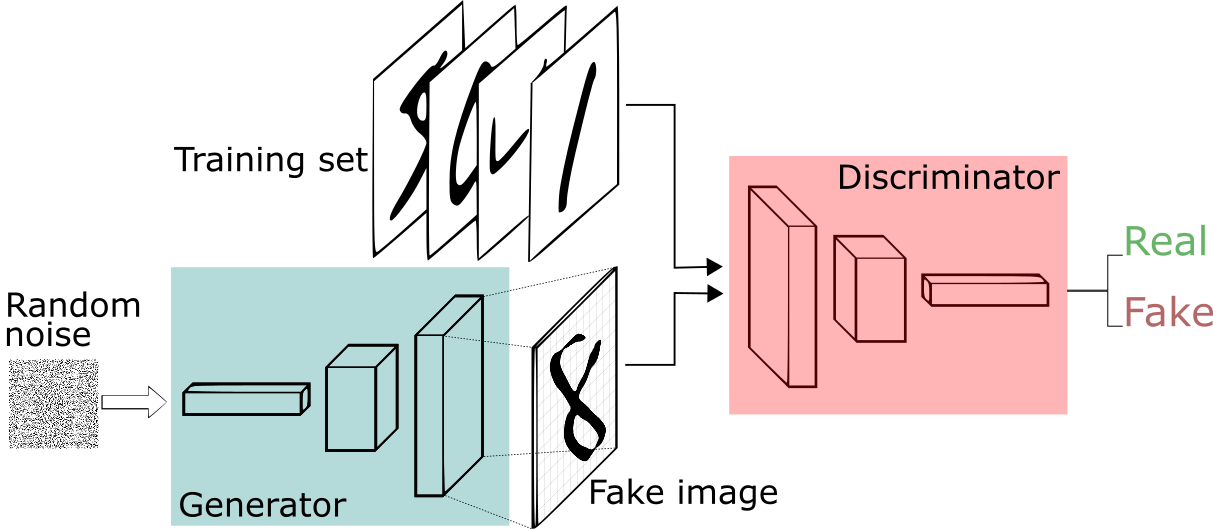


The generator in a DCGAN doesn't directly see the generated image being labelled "fake" by the discriminator. Instead, it uses the **discriminator's loss** as an indirect signal to improve its image generation. Here's how it works:

**The Training Process:**

1. **Generate Noise and Fake Images:** The generator takes a random noise vector as input and creates an image.
2. **Discriminate Real vs. Fake:** Both the real data (from the training dataset) and the generated image (fake data) are fed into the discriminator.
3. **Loss Calculation:** The discriminator calculates its loss for both the real and fake data. The loss represents how well the discriminator distinguished between real and fake.

   * Ideally, the discriminator loss should be high for fake images (because the discriminator failed to identify them as fake) and low for real images (because the discriminator correctly identified them as real).
4. **Backpropagation:** Here's the key part: The generator's weights and biases are updated based on the **discriminator's loss for the fake image**. This backpropagation process uses the chain rule to calculate how changes in the generator's parameters would have affected the discriminator's loss.

**How the Generator Learns:**

* A high discriminator loss for the fake image indicates that the generated image fooled the discriminator too easily. This tells the generator it needs to improve its output to be more realistic and trick the discriminator better.
* Backpropagation guides the generator in adjusting its weights and biases in a way that will hopefully reduce the discriminator's loss in the next iteration. Over many training iterations, the generator gradually learns to produce images that are increasingly difficult for the discriminator to classify as fake.

**It's an Adversarial Process:**

* This is essentially an adversarial training process. The generator is like a forger trying to create increasingly convincing counterfeits, while the discriminator acts as a security guard trying to improve its detection abilities.
* Through this competition, both the generator and discriminator become better at their respective tasks. The generator learns to create more realistic images, and the discriminator becomes more adept at spotting fakes.

**Important Note:**

* The generator doesn't directly receive information about what makes the generated image "fake." It only gets a signal through the discriminator's loss. The generator essentially learns to navigate the complex parameter space to find a region that produces outputs that minimize the discriminator's loss.

# Configurations

In [3]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [26]:
device = 'cuda'
batch_size = 128
noise_dim = 64

# optimizer params
lr = 0.0002
beta1 = 0.4
beta2 = 0.999
relu_negative_slope = 0.2
random_rotation = 10

# training params
epochs = 20

# Load MNIST Dataset

In [5]:
from torchvision import datasets, transforms as T

In [6]:
train_transformers = T.Compose([
    T.RandomRotation(((-1)*random_rotation, random_rotation)),
    T.ToTensor()
])

In [7]:
trainset = datasets.MNIST('MNIST/', download = True, transform = train_transformers)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 956996.97it/s] 


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133973.43it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1275673.92it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9714701.05it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



Shape of trainset: torch.Size([60000, 28, 28])
Shape of trainset item: torch.Size([28, 28])
Label of trainset item: 5


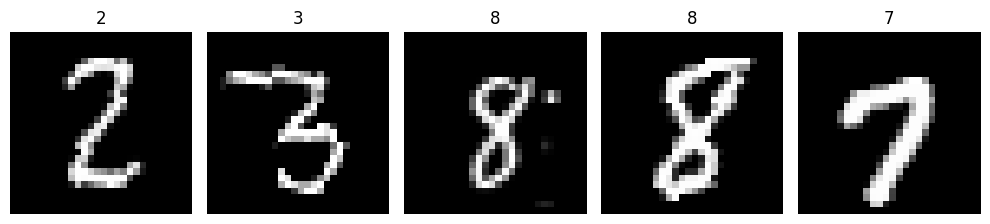

In [8]:
print(f"Shape of trainset: {trainset.data.shape}")
print(f"Shape of trainset item: {trainset.data[0].shape}")
print(f"Label of trainset item: {trainset.targets[0]}")
# show some random data items
indexes = np.random.randint(0, len(trainset), 5)

fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes_flat = axes.ravel()
for i, ax in enumerate(axes.flat):
    image, label = trainset[indexes[i]]
    axes_flat[i].set_title(label)
    axes_flat[i].axis('off')
    axes_flat[i].imshow(image.squeeze(), cmap='gray')
plt.tight_layout()
plt.show()

# Load Dataset Into Batches

In [9]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

for img, _ in trainloader:
  print(f"Shape of images: {img.shape}")
  break

Shape of images: torch.Size([128, 1, 28, 28])


In [11]:
def show_tensor_images(images, num_images = 16, size=(1, 28, 28)):
    unflat_img = images.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

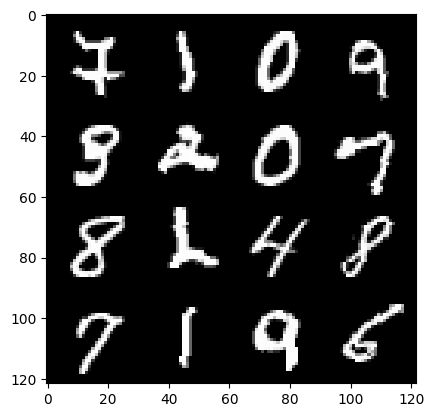

In [12]:
show_tensor_images(img)

# Create Discriminator Network

In [13]:
#In case if torch summary is not installed
!pip install torchsummary

In [14]:
from torch import nn
from torchsummary import summary

#### Discriminator Network Architecture


| Layer | Input Shape | Output Shape | Description |
|---|---|---|---|
| Conv2d | (bs, 1, 28, 28) | (bs, 16, 13, 13) | Applies a 2D convolution with 16 filters of size (3, 3) and stride 2. |
| BatchNorm2d | (bs, 16, 13, 13) | (bs, 16, 13, 13) | Normalizes the activations of the previous layer. |
| LeakyReLU | (bs, 16, 13, 13) | (bs, 16, 13, 13) | Applies a Leaky ReLU activation function. |
| --- | --- | --- | --- |
| Conv2d | (bs, 16, 13, 13) | (bs, 32, 5, 5) | Applies a 2D convolution with 32 filters of size (5, 5) and stride 2. |
| BatchNorm2d | (bs, 32, 5, 5) | (bs, 32, 5, 5) | Normalizes the activations of the previous layer. |
| LeakyReLU | (bs, 32, 5, 5) | (bs, 32, 5, 5) | Applies a Leaky ReLU activation function. |
| --- | --- | --- | --- |
| Conv2d | (bs, 32, 5, 5) | (bs, 64, 1, 1) | Applies a 2D convolution with 64 filters of size (5, 5) and stride 2. |
| BatchNorm2d | (bs, 64, 1, 1) | (bs, 64, 1, 1) | Normalizes the activations of the previous layer. |
| LeakyReLU | (bs, 64, 1, 1) | (bs, 64, 1, 1) | Applies a Leaky ReLU activation function. |
| --- | --- | --- | --- |
| Flatten | (bs, 64, 1, 1) | (bs, 64) | Flattens the spatial dimensions of the feature map. |
| Linear | (bs, 64) | (bs, 1) | Applies a fully connected layer with 1 output unit. |

**Summary:**

* The network takes an input image of size (bs, 1, 28, 28), where:
    * `bs` is the batch size.
    * The image has one channel (grayscale).
    * The image is 28x28 pixels.
* The network progressively extracts features from the image using convolutional layers with Leaky ReLU activations.
* Batch normalization is applied after each convolutional layer to improve training stability.
* The network then uses a fully connected layer to produce a single output value between 0 and 1, indicating the probability that the input image is real.

**Note:**

* LeakyReLU is used as the activation function to avoid the dying ReLU problem.

This architecture is a common example of a DCGAN discriminator, but variations can exist depending on the specific application.

In [15]:
def disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(relu_negative_slope)
  )

In [16]:
class Descriminator(nn.Module):
  def __init__(self):
    super(Descriminator, self).__init__()

    self.block1 = disc_block(1, 16, (3,3), 2)
    self.block2 = disc_block(16, 32, (5,5), 2)
    self.block3 = disc_block(32, 64, (5,5), 2)
    self.Flatten = nn.Flatten()
    self.Linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, images):
    x = self.block1(images)
    x = self.block2(x)
    x = self.block3(x)
    x = self.Flatten(x)
    x = self.Linear(x)
    return x

In [17]:
D = Descriminator().to(device)
summary(D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

#### Generator Network Architecture

| Layer | Input Shape | Output Shape | Description |
|---|---|---|---|
| Reshape | (bs, z_dim) | (bs, z_dim, 1, 1) | Reshapes the input vector into a feature map suitable for deconvolution. |
| --- | --- | --- | --- |
| ConvTranspose2d | (bs, z_dim, 1, 1) | (bs, 256, 3, 3) | Applies a transposed 2D convolution with 256 filters of size (3, 3) and stride 2. |
| BatchNorm2d | (bs, 256, 3, 3) | (bs, 256, 3, 3) | Normalizes the activations of the previous layer. |
| ReLU | (bs, 256, 3, 3) | (bs, 256, 3, 3) | Applies a ReLU activation function. |
| --- | --- | --- | --- |
| ConvTranspose2d | (bs, 256, 3, 3) | (bs, 128, 6, 6) | Applies a transposed 2D convolution with 128 filters of size (4, 4) and stride 1. |
| BatchNorm2d | (bs, 128, 6, 6) | (bs, 128, 6, 6) | Normalizes the activations of the previous layer. |
| ReLU | (bs, 128, 6, 6) | (bs, 128, 6, 6) | Applies a ReLU activation function. |
| --- | --- | --- | --- |
| ConvTranspose2d | (bs, 128, 6, 6) | (bs, 64, 13, 13) | Applies a transposed 2D convolution with 64 filters of size (3, 3) and stride 2. |
| BatchNorm2d | (bs, 64, 13, 13) | (bs, 64, 13, 13) | Normalizes the activations of the previous layer. |
| ReLU | (bs, 64, 13, 13) | (bs, 64, 13, 13) | Applies a ReLU activation function. |
| --- | --- | --- | --- |
| ConvTranspose2d | (bs, 64, 13, 13) | (bs, 1, 28, 28) | Applies a transposed 2D convolution with 1 filter of size (4, 4) and stride 2 to generate the image. |
| Tanh | (bs, 1, 28, 28) | (bs, 1, 28, 28) | Applies a Tanh activation function to ensure the output pixel values are between -1 and 1. |

**Summary:**

* The network takes a random noise vector of size `z_dim` as input.
* This noise vector is reshaped into a feature map suitable for deconvolution.
* The network uses transposed convolutional layers to progressively increase the spatial resolution of the feature maps and generate an image.
* Batch normalization and ReLU activations are used after each transposed convolution except for the last layer.
* The final layer uses a Tanh activation to constrain the pixel values of the generated image between -1 and 1.

**Note:**

* This is a common architecture for a DCGAN generator, but variations can exist depending on the specific application.

In [18]:
def gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
  if final_block:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [19]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block1 = gen_block(self.noise_dim, 256, (3,3), 2)
    self.block2 = gen_block(256, 128, (4,4), 1)
    self.block3 = gen_block(128, 64, (3,3), 2)
    self.block4 = gen_block(64, 1, (4,4), 2, final_block=True)

  def forward(self, noise_vector):
    x = noise_vector.view(-1, self.noise_dim, 1, 1)
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return x

In [20]:
G = Generator(noise_dim).to(device)
summary(G, (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
         LeakyReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
         LeakyReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
         LeakyReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [21]:
# Replace Random initialized weights to Normal weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [22]:
D = D.apply(weights_init)
G = G.apply(weights_init)


# Loss Functions & Optimizers

In [23]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_true = torch.ones_like(disc_pred)
  return criterion(disc_pred, ground_true)

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_true = torch.zeros_like(disc_pred)
  return criterion(disc_pred, ground_true)


In [24]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta1, beta2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta1, beta2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.4818666393695864 | G_loss : 1.3360628597517765


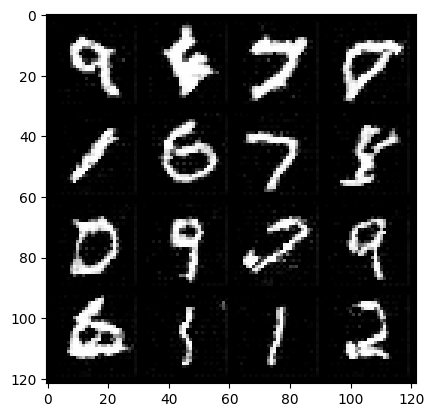

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.47738634313601674 | G_loss : 1.3423754274209678


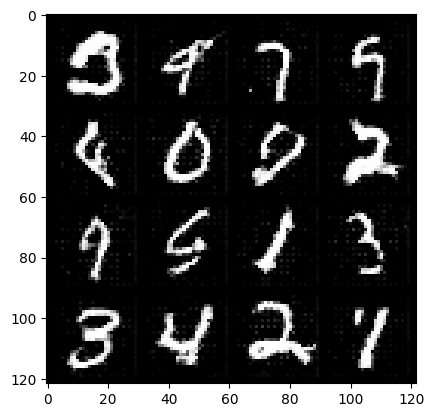

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.47674628215303805 | G_loss : 1.3515309878249666


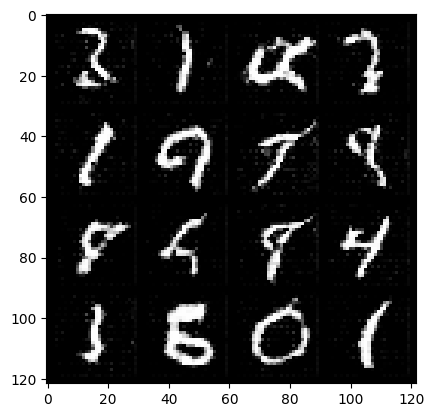

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.4723686364286744 | G_loss : 1.3727315228376815


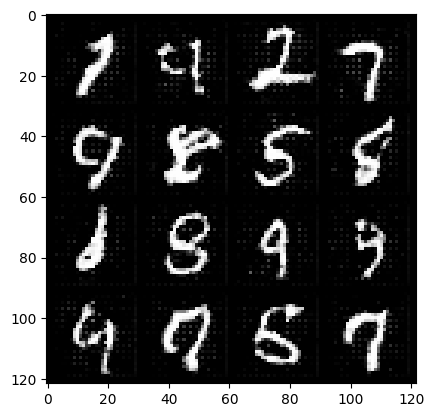

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.4768682585469187 | G_loss : 1.368916827732566


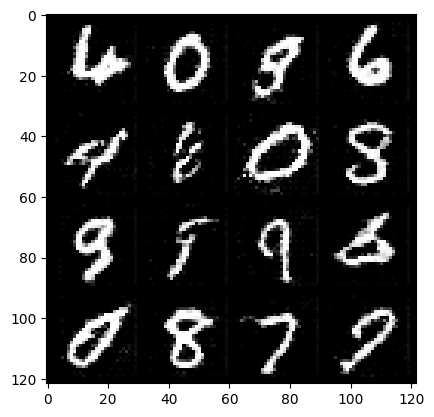

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.4692345242510472 | G_loss : 1.3848400502316733


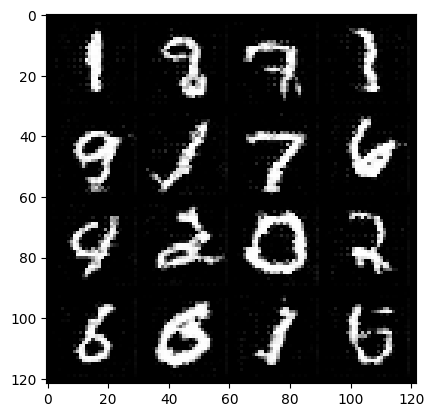

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.4686765011185522 | G_loss : 1.4007108247102196


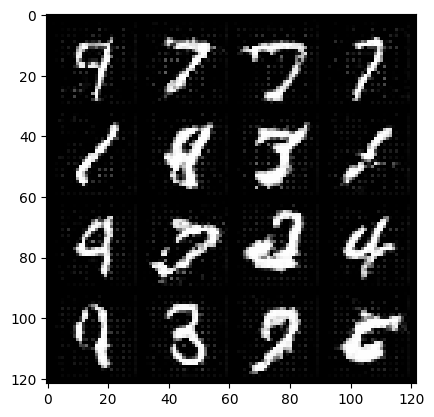

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.4694200491727288 | G_loss : 1.3901020695151551


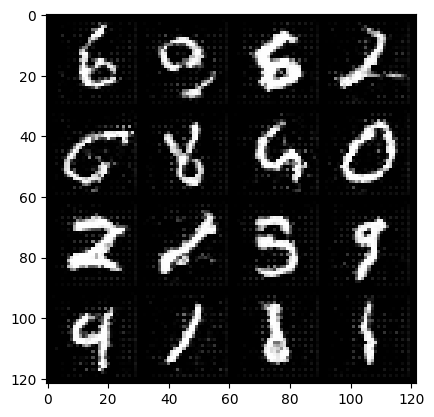

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.4688309788831007 | G_loss : 1.3929278962393559


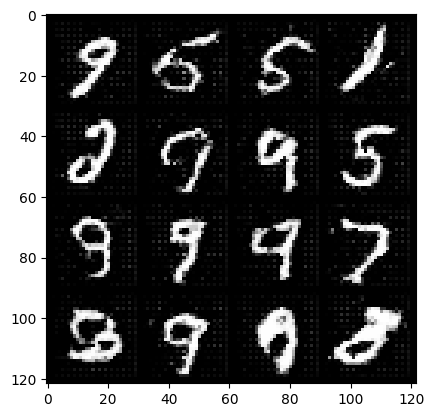

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.4727911856382895 | G_loss : 1.3965715182615495


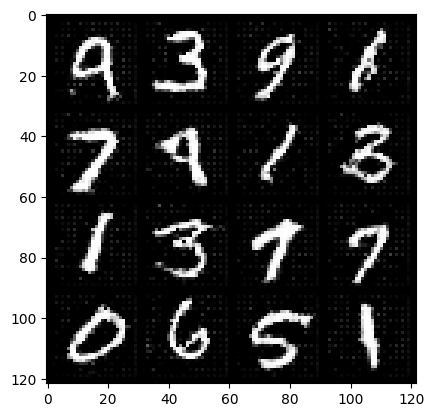

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.4734980671771808 | G_loss : 1.3907240022982617


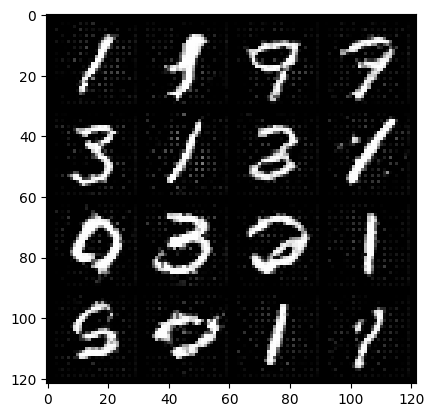

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.46646041529519217 | G_loss : 1.4103773670918398


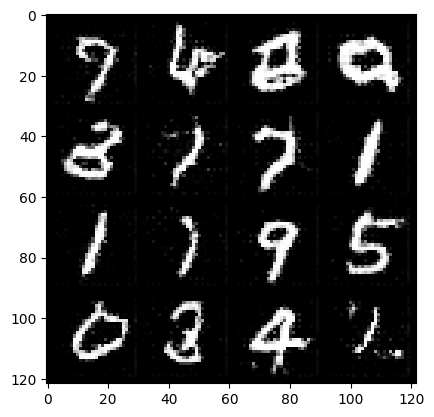

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.4666371483411362 | G_loss : 1.4195263498881732


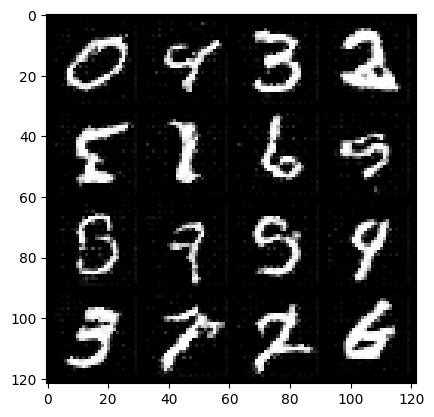

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.465310422024493 | G_loss : 1.4303100210771378


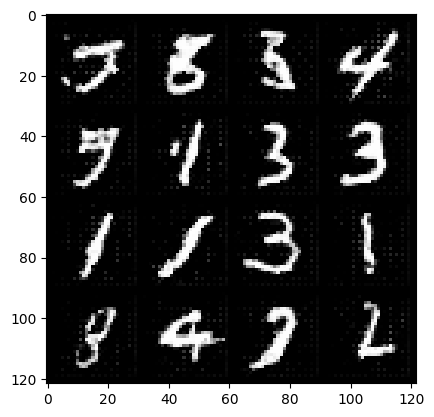

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.4654291887908602 | G_loss : 1.4317993437811765


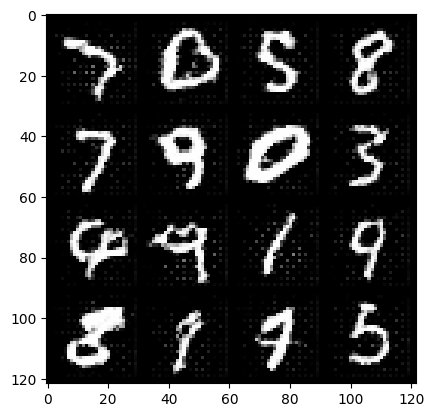

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.4636947310555464 | G_loss : 1.4291064194016365


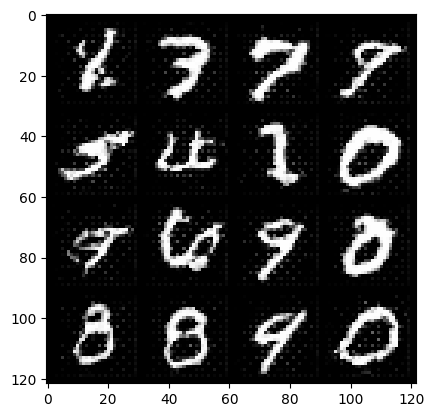

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.47332744818252287 | G_loss : 1.4181176225767969


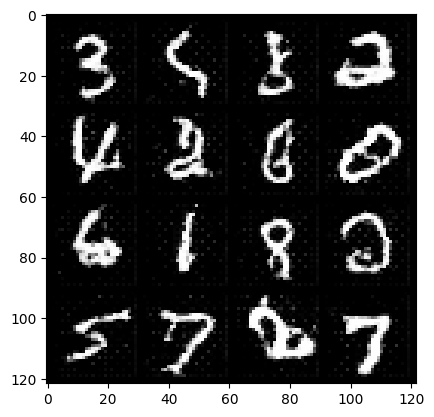

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.46677853233778654 | G_loss : 1.4253803936403189


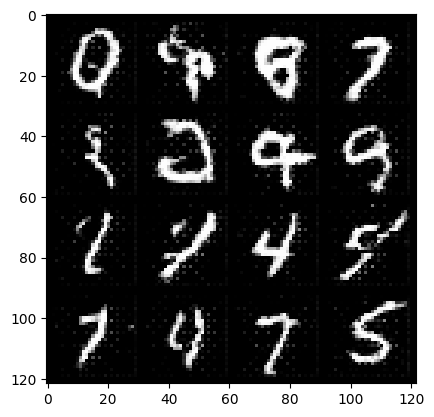

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.4662771717444666 | G_loss : 1.4310990531307293


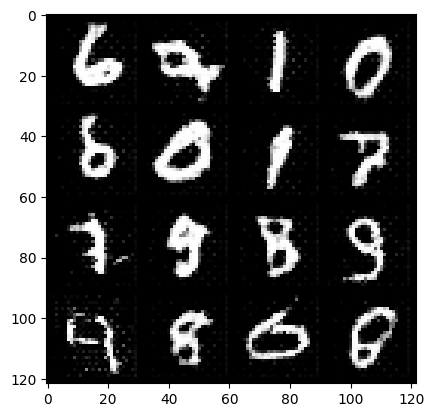

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.47165108534064626 | G_loss : 1.4140703948830236


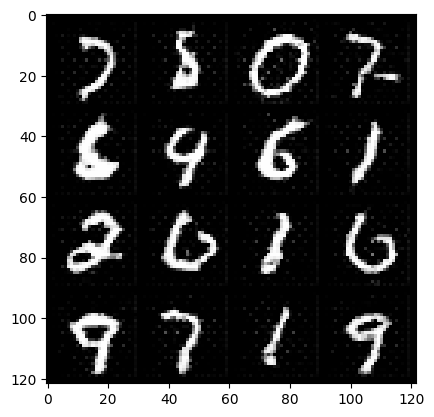

In [27]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_image, _ in tqdm(trainloader):
    real_image = real_image.to(device)

    # find loss and update weights for D
    noise = torch.randn(batch_size, noise_dim, device = device)
    D_opt.zero_grad()
    fake_img = G(noise)
    D_real_pred = D(real_image)
    D_fake_pred = D(fake_img)
    D_real_loss = real_loss(D_real_pred)
    D_fake_loss = fake_loss(D_fake_pred)
    D_loss = (D_real_loss + D_fake_loss)/2
    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    # find loss and update weights for G
    noise = torch.randn(batch_size, noise_dim, device = device)
    G_opt.zero_grad()
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)
    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  print(f"Epoch : {i+1} | D_loss : {total_d_loss/len(trainloader)} | G_loss : {total_g_loss/len(trainloader)}")
  show_tensor_images(fake_img)


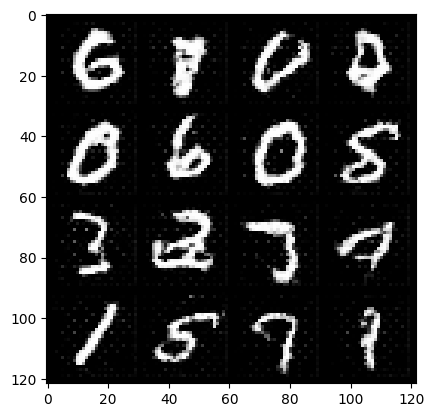

In [29]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)